In this notebook two deep learning methods are tested for air pollution prediction. **LSTM** and **CNN**. 

Univariate and Multivariate models are created to compare how a larger number of features affects the accuracy of the forecasts.


In the univariate models only values from previous days are used to make a prediction, whereas, in the multivariate models, weather forecast features are also taken in account for the prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import log
import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import optimizers
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

In [2]:
def split_ts_by_window(time_series, n_steps):
    window, output = list(), list()
    
    #UNIVARIATE MODEL
    if(isinstance(time_series, pd.Series)):
        for i in range(len(time_series)):
        
            #'n_steps' IS THE NUMBER OF PREVIOUS OBSERVATIONS I USED TO PREDICT THE NEXT VALUE
            #CREATE A WINDOW OF 'n_steps'
            window_limit = i + n_steps

            #IF THE END OF THE TIME SERIES IS REACHED BREAK THE LOOP
            if window_limit > len(time_series)-1:
                break

            #STORE EACH SEQUENCE OF 'n_steps' OBSERVATIONS TO THE 'window' LIST, WHICH IS GOING TO BE THE MODEL INPUT
            #AND STORE THE OUTPUT VALUE WHICH IS THE OBSERVATION AFTER THE END OF THE WINDOW
            input_features, output_pollutant = time_series[i:window_limit], time_series[window_limit]

            window.append(input_features)
            output.append(output_pollutant)
    
    #MULTIVARIATE MODEL
    else:
        
        for i in range(len(time_series)):
        
            #'n_steps' IS THE NUMBER OF PREVIOUS OBSERVATIONS I USED TO PREDICT THE NEXT VALUE
            #CREATE A WINDOW OF 'n_steps'
            window_limit = i + n_steps

            #IF THE END OF THE TIME SERIES IS REACHED BREAK THE LOOP
            if window_limit > len(time_series):
                break

            #STORE EACH SEQUENCE OF 'n_steps' OBSERVATIONS TO THE 'window' LIST, WHICH IS GOING TO BE THE MODEL INPUT
            #AND STORE THE OUTPUT VALUE COMING FROM 'n_steps' WINDOW USED

            #THE OUTPUT VALUES ARE THOSE OF THE FIRST COLUMN (POLLUTANT COLLUMN)
            input_features, output_pollutant = time_series[i:window_limit,:], time_series[window_limit-1,0]
            
            window.append(input_features)
            output.append(output_pollutant)
        
    return np.asarray(window).astype('float32'), np.asarray(output).astype('float32')

In [3]:
#GATHER Paris DATA FROM ALL AVAILABLE YEARS
Paris_Data = pd.read_csv('Paris_data.csv', index_col=0)

In [4]:
#Paris DATA PREVIEW
Paris_Data

,no2,o3,pm10,pm25,so2,temp,dew,humidity,windgust,windspeed,winddir
2014-12-29,26.1,3.7,29.0,74.0,2.1,0.1,-3.2,78.7,32.2,16.5,299.8
2014-12-30,28.8,4.5,29.0,68.0,2.1,3.4,0.5,82.3,24.6,11.1,314.3
2014-12-31,38.4,3.7,43.0,94.0,2.1,3.5,-0.3,76.8,13.7,6.9,217.8
2015-01-01,33.9,9.4,42.0,113.0,1.6,1.4,-1.7,81.0,27.3,15.7,197.4
2015-01-02,28.8,6.5,27.0,73.0,1.1,5.4,2.6,83.0,33.0,19.6,235.1
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-14,16.0,22.1,17.0,35.0,0.3,9.5,4.3,72.7,29.5,13.8,160.3
2022-03-15,24.1,9.9,16.0,47.0,0.3,10.1,8.1,88.1,23.2,12.4,115.5
2022-03-16,20.0,6.4,33.0,61.0,0.3,11.2,8.6,84.7,54.6,20.5,158.3
2022-03-17,11.1,23.0,16.0,39.0,0.3,8.8,4.3,73.4,43.5,21.5,135.6


## Data Preparation for Univariate Models

In [5]:
#DATA PREPARATION FOR UNIVARIATE MODELS

#KEEP ONLY THE POLLUTANTS COLUMNS
cols=['pm25', 'pm10', 'no2', 'o3', 'so2']

#MAKE VALUES NUMERIC
Paris_Data_uni = Paris_Data.loc[:, Paris_Data.columns.intersection(cols)]
Paris_Data_uni = Paris_Data_uni.apply(pd.to_numeric, errors='coerce')

#FILL NAN VALUES
Paris_Data_uni = Paris_Data_uni.iloc[1: , :]

#SOME VALUES ARE EMPTY, BUT NOT RECOGNIZED AS NAN. REPLACE EMPTY VALUES WITH NAN TO FILL THEM LATER
Paris_Data_uni = Paris_Data_uni.replace(r'^\s*$', np.nan, regex=True)
Paris_Data_uni = Paris_Data_uni.fillna(method='ffill')
Paris_Data_uni = Paris_Data_uni.fillna(method='bfill')

#REMOVE DUPLICATE VALUES
Paris_Data_uni = Paris_Data_uni[~Paris_Data_uni.index.duplicated(keep='first')]

In [6]:
#UNIVARIATE DATA PREVIEW
Paris_Data_uni

,no2,o3,pm10,pm25,so2
2014-12-30,28.8,4.5,29.0,68.0,2.1
2014-12-31,38.4,3.7,43.0,94.0,2.1
2015-01-01,33.9,9.4,42.0,113.0,1.6
2015-01-02,28.8,6.5,27.0,73.0,1.1
2015-01-03,19.2,8.2,13.0,46.0,0.6
...,...,...,...,...,...
2022-03-14,16.0,22.1,17.0,35.0,0.3
2022-03-15,24.1,9.9,16.0,47.0,0.3
2022-03-16,20.0,6.4,33.0,61.0,0.3
2022-03-17,11.1,23.0,16.0,39.0,0.3


## Data preparation for Multivariate Models

In [7]:
#DATA PREPARATION FOR MULTIVARIATE MODELS

#ALL COLUMNS
Paris_Data.columns

Index(['no2', 'o3', 'pm10', 'pm25', 'so2', 'temp', 'dew', 'humidity',
       'windgust', 'windspeed', 'winddir'],
      dtype='object')

In [8]:
#SOME VALUES ARE EMPTY, BUT NOT RECOGNIZED AS NAN. REPLACE EMPTY VALUES WITH NAN TO FILL THEM LATER
Paris_Data = Paris_Data.replace(r'^\s*$', np.nan, regex=True)

#DECIDE WHICH COLUMNS TO KEEP BASED ON HOW MANY MISSING VALUES THERE ARE. IF A COLUMNS HAS A FEW MISSING VALUES,
#COMPARED TO THE LENGTH OF THE DATAFRAME, THEN KEEP IT. OTHERWISE, DROP IT.

(Paris_Data).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windgust     0
windspeed    0
winddir      0
dtype: int64

In [9]:
#MAKE THE REMAINING COLUMNS NUMERIC
cols=['pm25', 'pm10', 'no2', 'o3', 'so2', 'windspeed', 'humidity', 'winddir', 
      'temp', 'windgust', 'dew']

Paris_Data_multi = Paris_Data.loc[:, Paris_Data.columns.intersection(cols)]
Paris_Data_multi = Paris_Data_multi.apply(pd.to_numeric, errors='coerce')

In [10]:
(Paris_Data_multi).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windgust     0
windspeed    0
winddir      0
dtype: int64

In [11]:
#FILL NAN VALUES WITH BACKWARD FILLING AND CHECK THAT THERE ARE NONE LEFT
Paris_Data_multi = Paris_Data_multi.iloc[1: , :]
#Paris_Data_multi = Paris_Data_multi.fillna(method='bfill')
#Paris_Data_multi = Paris_Data_multi.fillna(method='ffill')
Paris_Data_multi = Paris_Data_multi.dropna()
(Paris_Data_multi).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windgust     0
windspeed    0
winddir      0
dtype: int64

In [12]:
pollutants = ['o3', 'so2', 'no2', 'pm25', 'pm10']
weather_conds = ['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew']

#CREATE FIVE DIFFERENT DATASETS, EACH CONTAINS ONE OF THE POLLUTANTS AND ALL THE WEATHER CONDITIONS
Paris_o3 = Paris_Data_multi.loc[:, Paris_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'o3'])]
Paris_so2 = Paris_Data_multi.loc[:, Paris_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'so2'])]
Paris_no2 = Paris_Data_multi.loc[:, Paris_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'no2'])]
Paris_pm25 = Paris_Data_multi.loc[:, Paris_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'pm25'])]
Paris_pm10 = Paris_Data_multi.loc[:, Paris_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'pm10'])]

datasets = [Paris_o3, Paris_no2, Paris_so2, Paris_pm10, Paris_pm25]

In [13]:
#MULTIVARIATE DATA PREVIEW
Paris_o3

,o3,temp,dew,humidity,windgust,windspeed,winddir
2014-12-30,4.5,3.4,0.5,82.3,24.6,11.1,314.3
2014-12-31,3.7,3.5,-0.3,76.8,13.7,6.9,217.8
2015-01-01,9.4,1.4,-1.7,81.0,27.3,15.7,197.4
2015-01-02,6.5,5.4,2.6,83.0,33.0,19.6,235.1
2015-01-03,8.2,6.9,5.9,93.1,54.3,32.0,216.8
...,...,...,...,...,...,...,...
2022-03-14,22.1,9.5,4.3,72.7,29.5,13.8,160.3
2022-03-15,9.9,10.1,8.1,88.1,23.2,12.4,115.5
2022-03-16,6.4,11.2,8.6,84.7,54.6,20.5,158.3
2022-03-17,23.0,8.8,4.3,73.4,43.5,21.5,135.6


# UNIVARIATE CNN

Univariate CNN RMSE for Paris[no2]:5.426646834359885


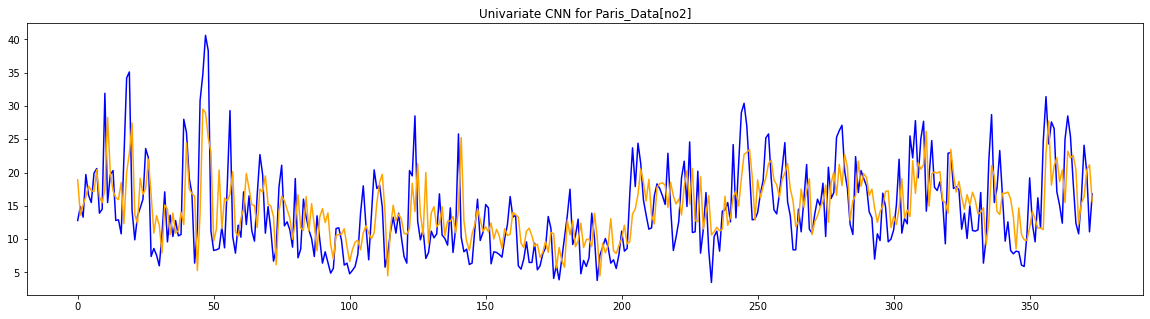

Univariate CNN RMSE for Paris[o3]:6.645740791401956


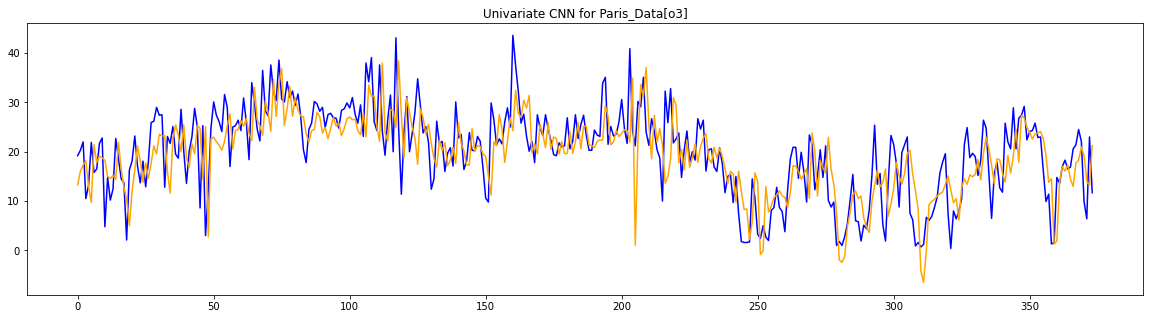

Univariate CNN RMSE for Paris[pm10]:7.79817681156773


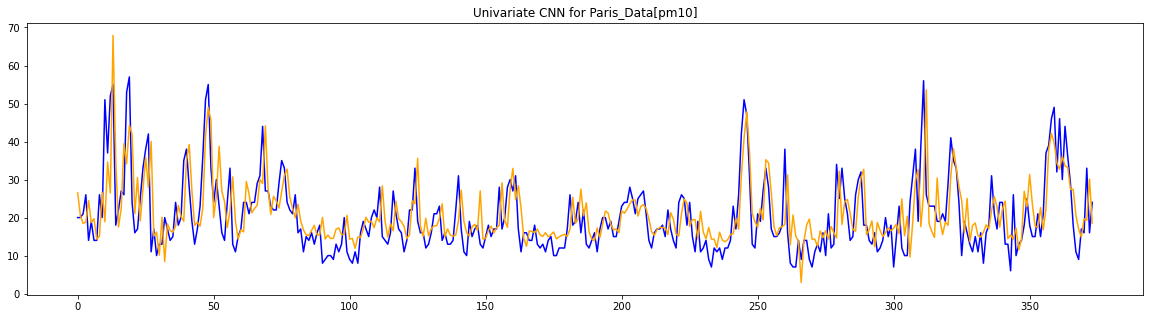

Univariate CNN RMSE for Paris[pm25]:16.38359857436985


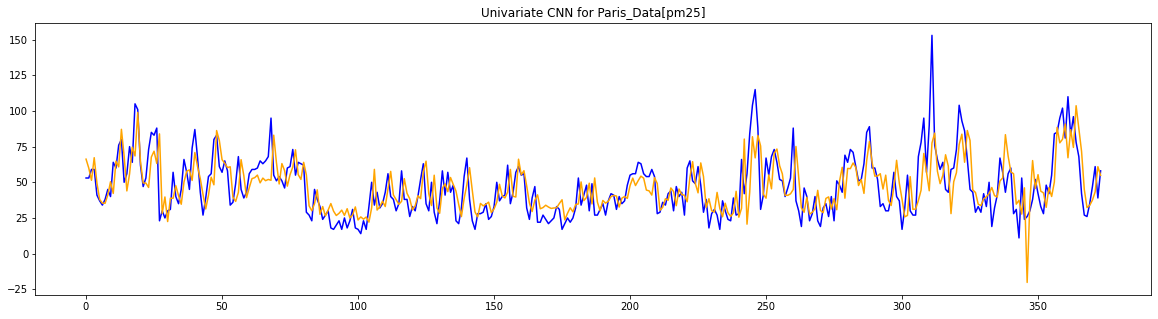

Univariate CNN RMSE for Paris[so2]:0.4864273736020523


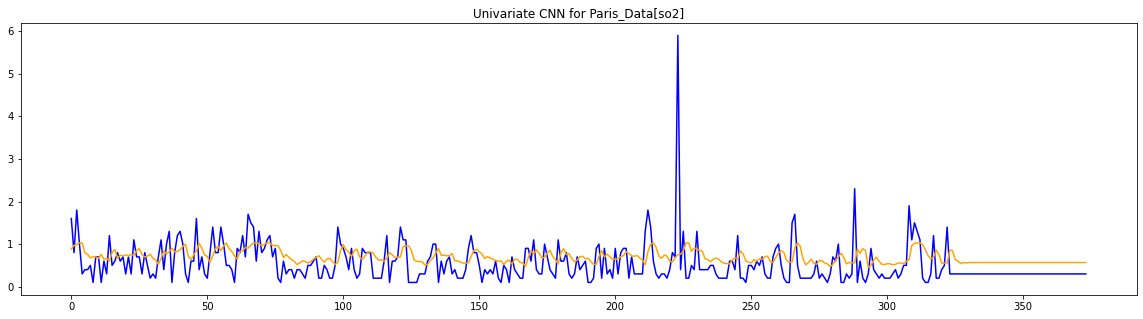

In [14]:
n_steps = 7
n_features = 1

#CNN UNIVARIATE MODEL
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

for col in Paris_Data_uni.columns:
    
    #SPLIT DATASET AND CREATE INPUT/OUTPUT USING A WINDOW OF 'n_steps'
    window, output = split_ts_by_window(Paris_Data_uni[col], n_steps)
    
    #RESHAPE INPUT TO PASS IT TO THE MODEL
    window = window.reshape((window.shape[0], window.shape[1], n_features))
    
    #SPLIT TO TRAIN AND TEST PORTIONS
    train_size = int(len(output) * 0.8)
    train_X, test_X = window[0:train_size], window[train_size:]
    train_y, test_y = output[0:train_size], output[train_size:]
    
    #FIT TRAIN DATA TO THE MODEL
    model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)
    
    #TEST THE MODEL ACCURACY
    test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
    
    #PREDICT THE TEST PORTION
    pred = model.predict(test_X, verbose=0)
    
    #CALCULATE RMSE FOR EACH TIME SERIES
    rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
    print("Univariate CNN RMSE for Paris[" + str(col) + "]:" + str(rmse_ucnn))
    
    title = "Univariate CNN for Paris_Data" + "[" + col +"]"
    
    # PLOT THE ACTUAL VS PREDICTED DATA
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(test_y, label='Actual Data', color='blue')
    plt.plot(pred, label='Predicted Data', color='orange')
    plt.show()

# MULTIVARIATE CNN

Multivariate CNN RMSE for Paris[o3]:2.6820158782705157


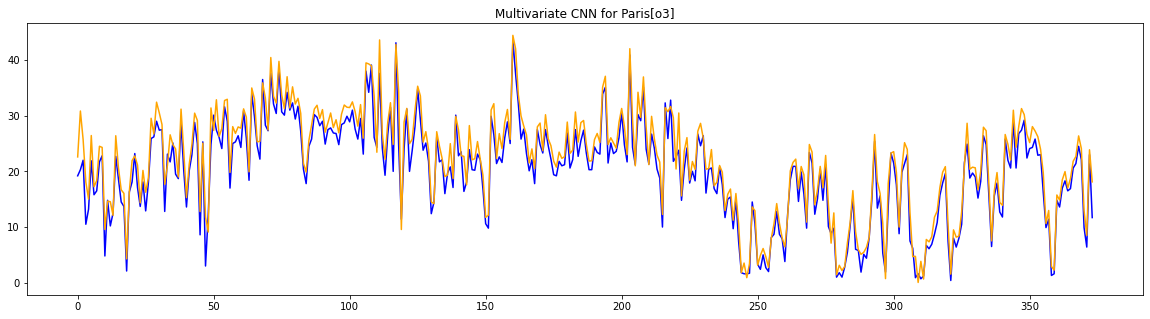

Multivariate CNN RMSE for Paris[no2]:1.300227141710591


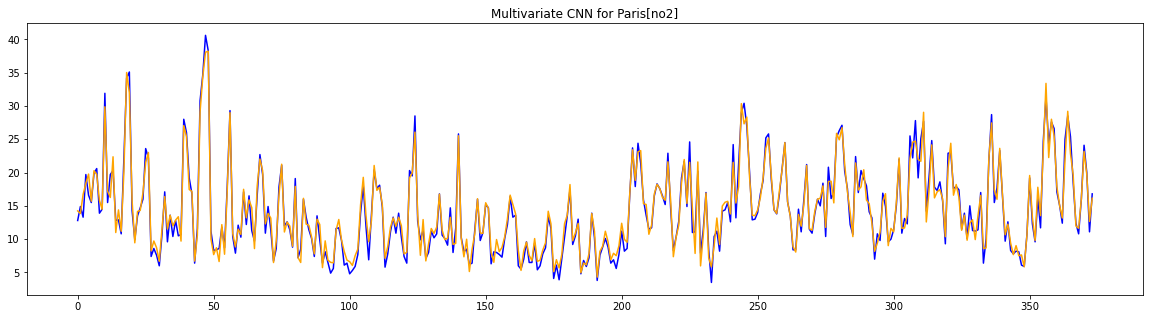

Multivariate CNN RMSE for Paris[so2]:0.23709725312822266


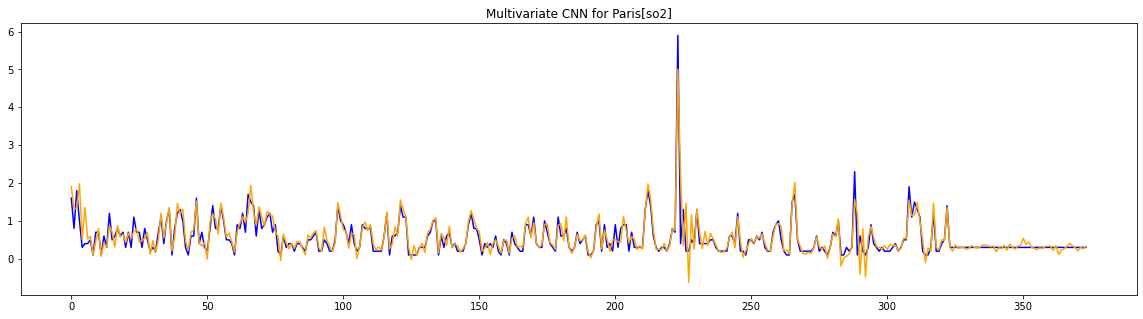

Multivariate CNN RMSE for Paris[pm10]:1.8840440070364144


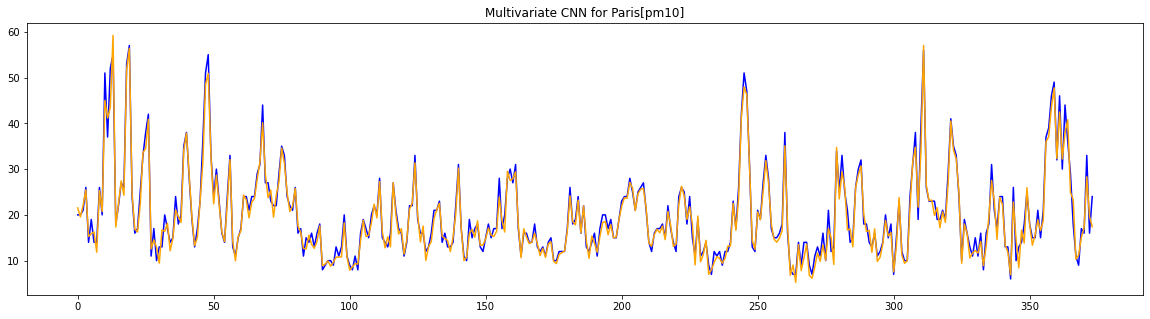

Multivariate CNN RMSE for Paris[pm25]:3.9034374640366063


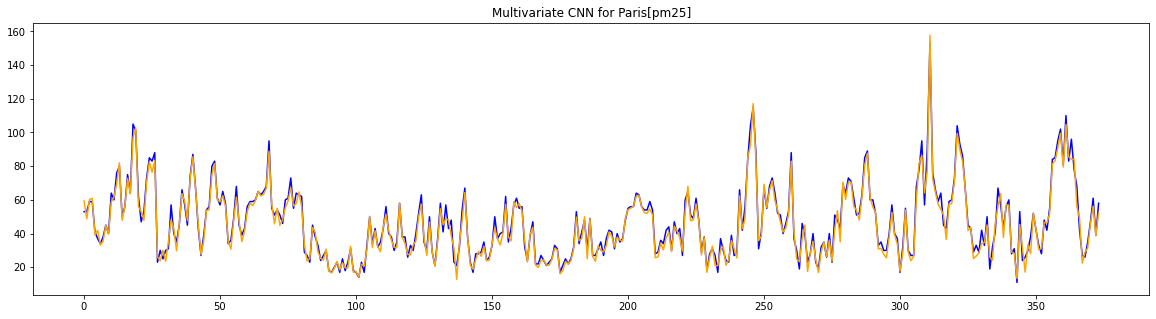

In [15]:
n_steps=7

for data in datasets:
    
    #SPLIT DATASET AND CREATE INPUT/OUTPUT USING A WINDOW OF 'n_steps'
    window, output = split_ts_by_window(np.asarray(data), n_steps)
      
    n_features= window.shape[2]
    
    #SPLIT TO TRAIN AND TEST PORTIONS
    train_size = int(len(output) * 0.8)
    train_X, test_X = window[0:train_size], window[train_size:]
    train_y, test_y = output[0:train_size], output[train_size:]
    
    #MULTIVARIATE CNN MODEL
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=2, input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    #FIT TRAIN DATA TO THE MODEL
    model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)
    
    #TEST THE MODEL ACCURACY
    test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
    
    #PREDICT THE TEST PORTION
    pred = model.predict(test_X, verbose=0)
    
    #CALCULATE RMSE FOR EACH TIME SERIES
    rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
    print("Multivariate CNN RMSE for Paris[" + str(data.columns[0]) + "]:" + str(rmse_ucnn))
    
    title = "Multivariate CNN for Paris[" + str(data.columns[0]) + "]"
    
    # PLOT THE ACTUAL VS PREDICTED DATA
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(test_y, label='Actual Data', color='blue')
    plt.plot(pred, label='Predicted Data', color='orange')
    plt.show()

# UNIVARIATE LSTM

Univariate LSTM RMSE for Paris[no2]:5.563300771616062


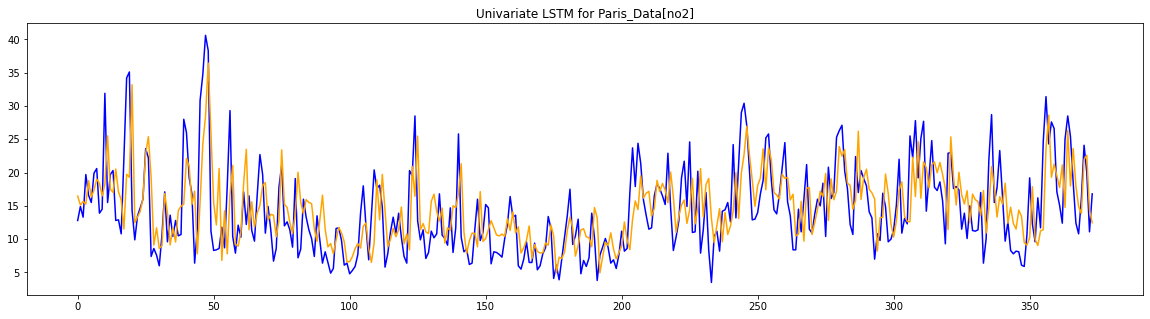

Univariate LSTM RMSE for Paris[o3]:7.136481955054901


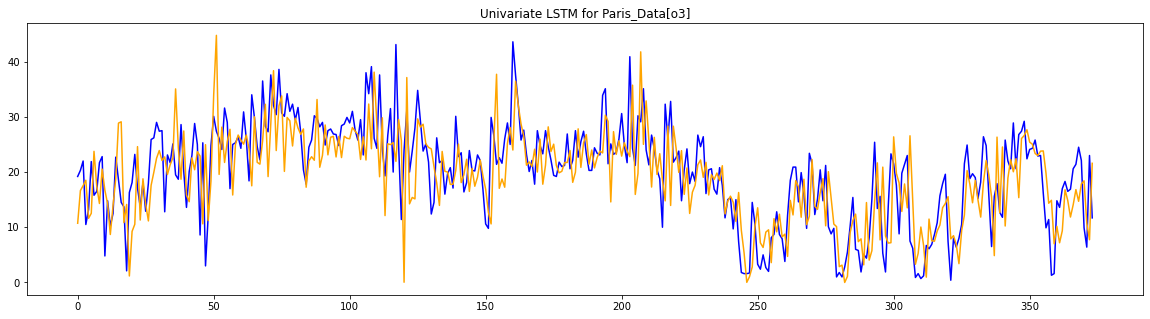

Univariate LSTM RMSE for Paris[pm10]:8.604979789927377


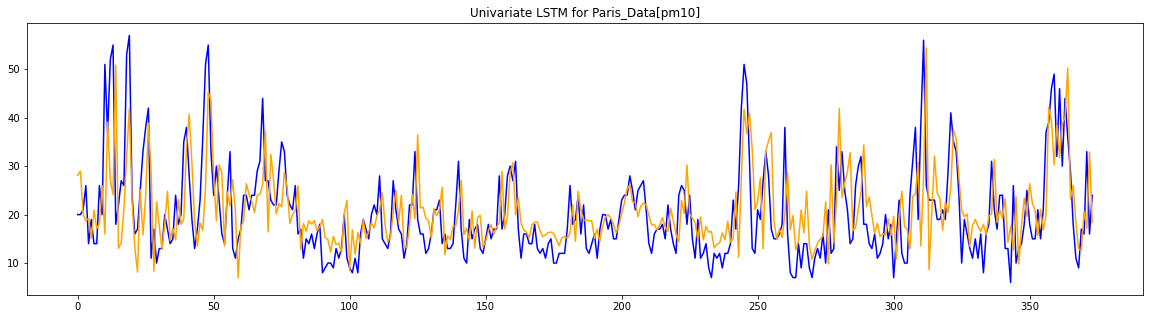

Univariate LSTM RMSE for Paris[pm25]:17.868962902336502


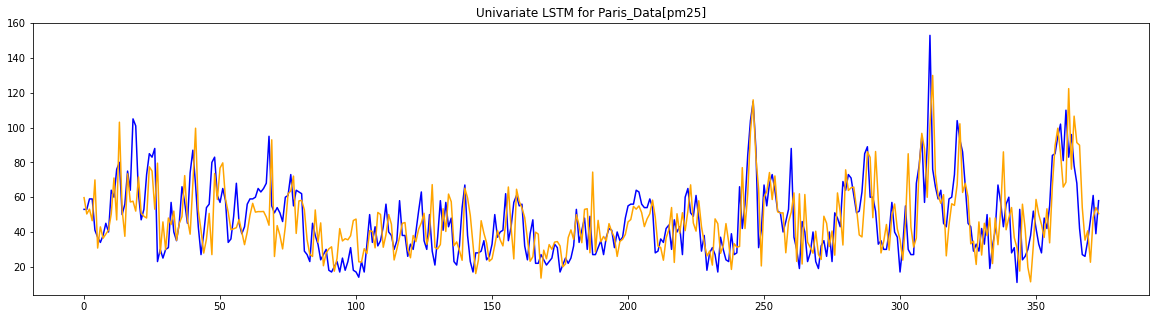

Univariate LSTM RMSE for Paris[so2]:0.46745486949400433


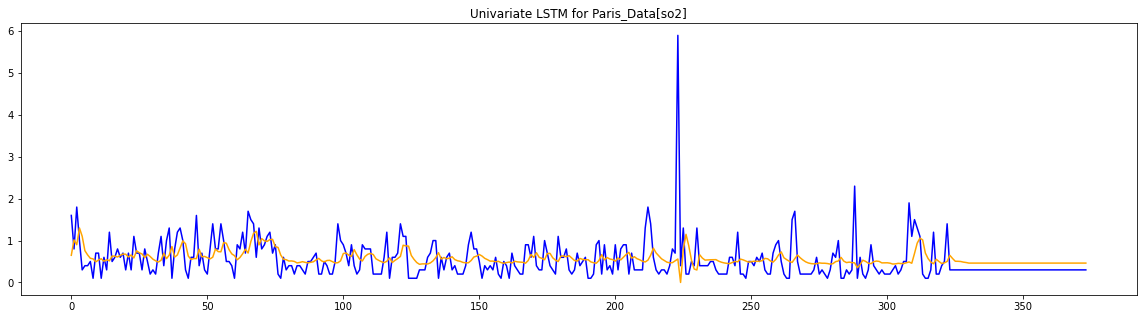

In [16]:
n_steps=7

for col in Paris_Data_uni.columns:
    window, output = split_ts_by_window(Paris_Data_uni[col], n_steps)
    
    #RESHAPE INPUT TO PASS IT TO THE MODEL
    window = window.reshape((window.shape[0], window.shape[1], 1))
    
    #UNIVARIATE LSTM MODEL
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(n_steps, 1), activation='relu'))
    lstm_model.add(Dense(30,activation='relu'))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1,activation='relu'))
    optimizer = optimizers.RMSprop(lr=0.0001)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #SPLIT TO TRAIN AND TEST PORTIONS
    train_size = int(len(output) * 0.8)
    train_X, test_X = window[0:train_size], window[train_size:]
    train_y, test_y = output[0:train_size], output[train_size:]
    
    #FIT TRAIN DATA TO THE MODEL
    lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)
    
    #TEST THE MODEL ACCURACY
    test_X = test_X.reshape((test_X.shape[0], n_steps, 1))
    
    #PREDICT THE TEST PORTION
    pred = lstm_model.predict(test_X, verbose=0)
    
    #CALCULATE RMSE FOR EACH TIME SERIES
    rmse_ulstm = math.sqrt(mean_squared_error(test_y, pred))
    print("Univariate LSTM RMSE for Paris[" + str(col) + "]:" + str(rmse_ulstm))
    
    title = "Univariate LSTM for Paris_Data" + "[" + col +"]"
    
    # PLOT THE ACTUAL VS PREDICTED DATA
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(test_y, label='Actual Data', color='blue')
    plt.plot(pred, label='Predicted Data', color='orange')
    plt.show()

# MULTIVARIATE LSTM

Multivariate LSTM RMSE for Paris[o3]:0.7305511999262294


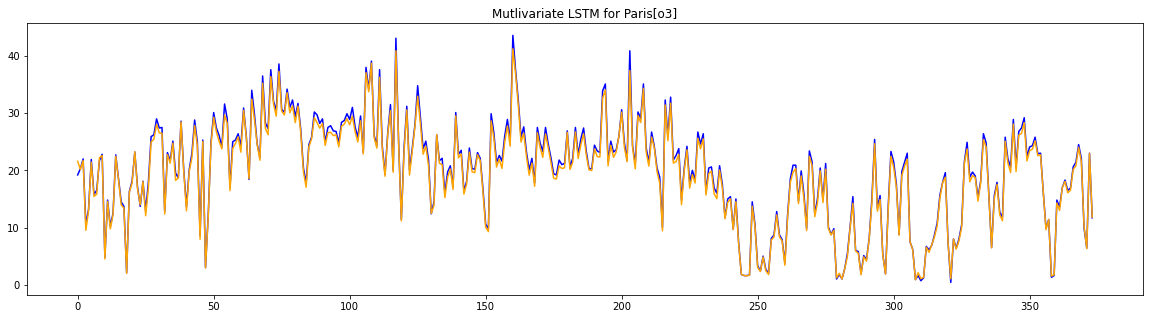

Multivariate LSTM RMSE for Paris[no2]:0.3757744382054516


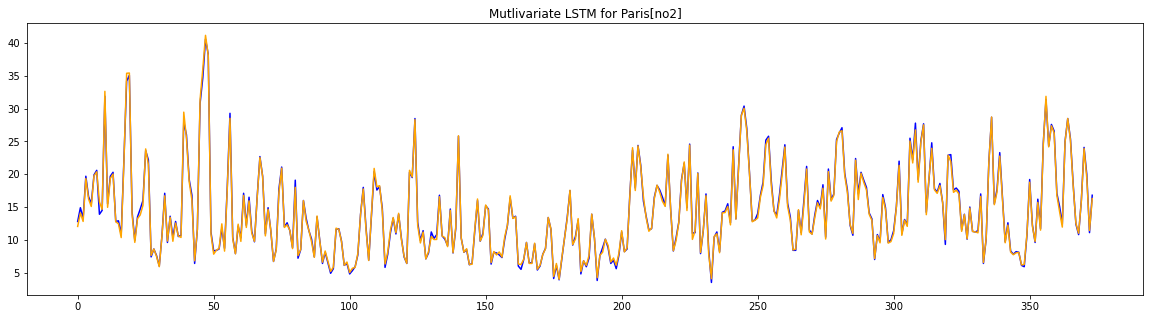

Multivariate LSTM RMSE for Paris[so2]:0.051727628003513715


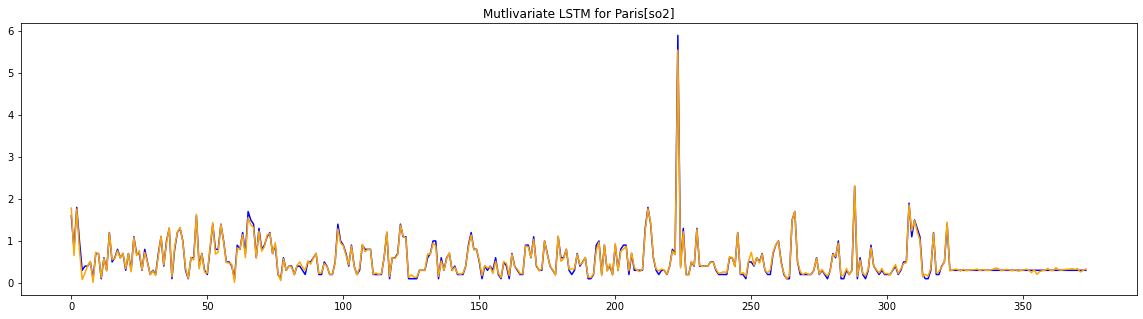

Multivariate LSTM RMSE for Paris[pm10]:0.48665093428622896


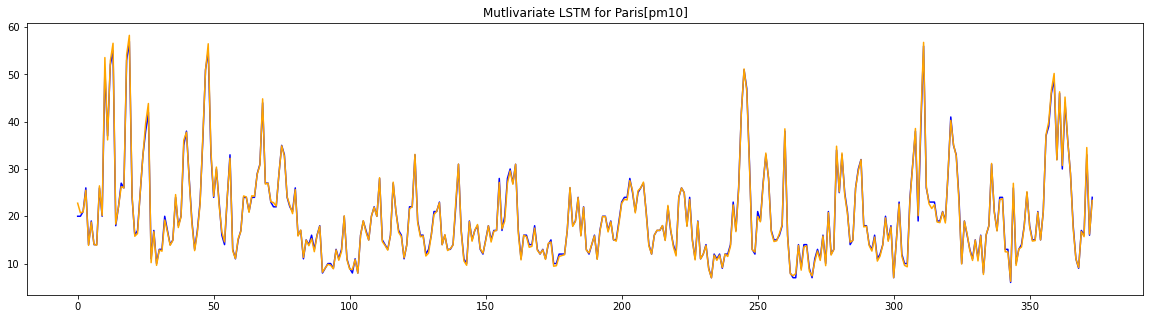

Multivariate LSTM RMSE for Paris[pm25]:1.832467293649112


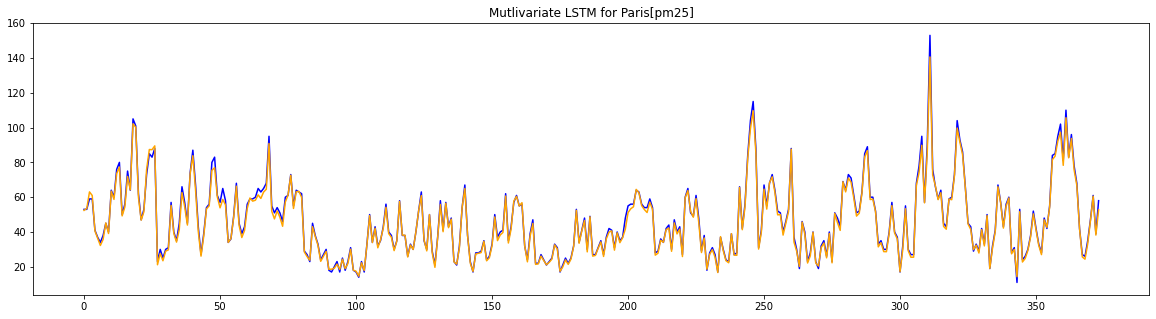

In [17]:
n_steps=7

for data in datasets:
    window, output = split_ts_by_window(np.asarray(data), n_steps)
    
    n_features = window.shape[2]
    
    
    #MULTIVARIATE LSTM MODEL
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(n_steps, n_features)))
    lstm_model.add(Dense(30))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1))
    optimizer = optimizers.RMSprop(lr=0.0001)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #SPLIT TO TRAIN AND TEST PORTIONS
    train_size = int(len(output) * 0.8)
    train_X, test_X = window[0:train_size], window[train_size:]
    train_y, test_y = output[0:train_size], output[train_size:]
    
    #FIT TRAIN DATA TO THE MODEL
    lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)
    
    #TEST THE MODEL ACCURACY
    test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
    
    #PREDICT THE TEST PORTION
    pred = lstm_model.predict(test_X, verbose=0)
    
    #CALCULATE RMSE FOR EACH TIME SERIES
    rmse_mlstm = math.sqrt(mean_squared_error(test_y, pred))
    print("Multivariate LSTM RMSE for Paris[" + str(data.columns[0]) + "]:" + str(rmse_mlstm))
    
    title = "Mutlivariate LSTM for Paris" + "[" + str(data.columns[0]) +"]"
    
    # PLOT THE ACTUAL VS PREDICTED DATA
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(test_y, label='Actual Data', color='blue')
    plt.plot(pred, label='Predicted Data', color='orange')
    plt.show()